# 基于数值优化的投资组合分析

+ 当卖空被限制时，优化问题变为有线性不等式约束的二次优化问题，优化变得非常复杂。
+ 优化形式..

+ 投资组合的优化问题就很难用简单的拉格朗日乘子法求解。我们需要借助于优化技术
+ 这节我们利用数值优化的计算投资组合

## 首先定义一些相关的函数

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from getsinadata import get_sina_stock


+ 首先我们利用sina数据得到日线复权数据
+ 其中ticker是股票代码字符串list

In [2]:
def get_historical_closes(ticker, start_date, end_date):
    for i in range(len(ticker)):    
        datat=get_sina_stock(ticker[i],start_date,end_date)
        close=datat["close"]
        #closew=close.resample(freq,how="last")
        #ret1=closew.pct_change()
        close.name=ticker[i]
        if i==0:
            data=close.copy()
        else:
            data=pd.concat([data,close],axis=1)  
    
    data=data.dropna(how="all")
    return data

In [5]:
#浙江龙盛，国金证券，建设银行
tickers=["600352","600109","601939"]
start_date="2008-1-1"
end_date="2015-1-1"
closes=get_historical_closes(tickers,start_date,end_date)
closes.head(2)

,600352,600109,601939
date,,,
2008-01-02,69.690,134.039,9.80
2008-01-03,71.583,136.308,9.72


+ 利用日数据计算各频率收益率

In [4]:
def calc_returns(closes,freq="W-FRI",tye="simple"):    
    returndaily=np.log(closes).diff()
    returns=returndaily.resample(freq).sum() 
    if tye=="simple":
        return np.exp(returns)-1
    elif tye=="log":
        return returns

In [6]:
returns=calc_returns(closes,"A")
returns


,600352,600109,601939
date,,,
2008-12-31,-0.701223,-0.681388,-0.584473
2009-12-31,2.002903,1.071294,0.614726
2010-12-31,0.135741,-0.373689,-0.172383
2011-12-31,-0.501891,-0.327483,0.054010
2012-12-31,0.090225,0.922835,0.063636
2013-12-31,1.213859,-0.032615,-0.040870
2014-12-31,0.453198,1.326045,0.751706


+ 我们定义投资组合的权重函数如下：

In [8]:
def create_portfolio(tickers, weights=None):
    if weights is None: 
        weights = np.ones(len(tickers))/len(tickers)
    portfolio = pd.DataFrame({'Tickers': tickers, 
                              'Weights': weights}, 
                             index=tickers)
    return portfolio

In [7]:
portfolio=create_portfolio(tickers,[0.5,0.2,0.3])
portfolio

,Tickers,Weights
600352,600352,0.5
600109,600109,0.2
601939,601939,0.3


+ 计算 投资组合收益率

In [8]:
def calculate_weighted_portfolio_value(portfolio, 
                                       returns, 
                                       name='Value'):
    total_weights = portfolio.Weights.sum()
    weighted_returns = returns * (portfolio.Weights / 
                                  total_weights)
    return pd.DataFrame({name: weighted_returns.sum(axis=1)})


+ 下面我们画出投资组合收益率和各资产收益率图形

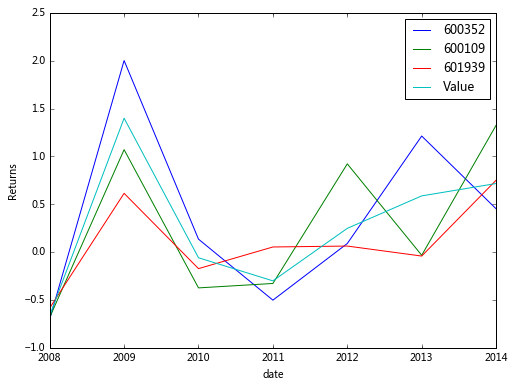

In [9]:
%matplotlib inline
portret=calculate_weighted_portfolio_value(portfolio,returns)
fig=plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
returns.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Returns')
portret.plot(ax=ax)

## 模拟

+ 投资组合的标准差计算如下
+ 投资组合表示简化

In [10]:
def calc_portfolio_std(returns=None,sigma=None, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    if returns is not None:
        sigma = returns.cov()
    ## the the same result as the  matrix dot
    var = weights.dot(sigma).dot(weights)
    return np.sqrt(var)

随机权重

In [11]:
def rand_weights(n,par1=0):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    k = k *(1+par1*n)/ sum(k)-par1
    return k

def rand_portfolio_meanstd(returns,par1=0,nsamples=500):
    sig = returns.cov()
    means=returns.mean()
    n_assets=returns.shape[1]
    out=[]
    for i in range(nsamples):
        weight=rand_weights(n_assets,0.2)
        std=calc_portfolio_std(sigma=sig,weights=weight)
        mean=sum(means*weight)
        out.append([mean,std])
    out=pd.DataFrame(out,columns=["mean","std"])
    return(out)


In [12]:
returns.head()

,600352,600109,601939
date,,,
2008-12-31,-0.701223,-0.681388,-0.584473
2009-12-31,2.002903,1.071294,0.614726
2010-12-31,0.135741,-0.373689,-0.172383
2011-12-31,-0.501891,-0.327483,0.054010
2012-12-31,0.090225,0.922835,0.063636


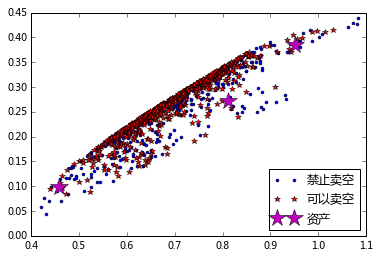

In [13]:
sim=rand_portfolio_meanstd(returns,par1=0.4,nsamples=500)
sim1=rand_portfolio_meanstd(returns,par1=0,nsamples=500)
std0=np.sqrt(returns.cov().values.diagonal())
mean0=returns.mean()
plt.figure()
plt.plot(sim1["std"],sim1["mean"], 'bo',markersize=3,label="禁止卖空")
plt.plot(sim["std"],sim["mean"], 'r*',markersize=6,label="可以卖空")
plt.plot(std0,mean0, 'm*',markersize=18,label="资产" )
plt.legend(loc="lower right")

## 优化

+ 有效前沿
+ 切线组合，





限制包括：

+ 权重和为1

可选限制：

+ 各权重是否在[0,1]之间


+ 有效组合的计算



假设有 N个资产，$R=(R_1,\cdots,R_N)^T$， 收益率的期望，协方差矩阵分别为：

$$E(R)=(\mu_1,\cdots,\mu_N)^T$$
$$Cov(R)=\Omega$$
投资组合权重为 $$\omega=(\omega_1,\cdots,\omega_N)$$

给定的预期收益率为$\mu_P$,求方差最小的投资组合的权重$\omega_P$

1. 没有卖空限制
2. 不得卖空


In [14]:
scopt.minimize?

+ 输入 

   
    import scipy.optimize as scopt 

+ minimize 函数
    
    Minimization of scalar function of one or more variables.

+ 语法：

```
编辑过：
Signature: scopt.minimize(fun, x0, args=(), method=None, bounds=None, constraints=(), tol=None)
```

+ 参数：
   + fun: 目标函数，第一个参数向量是优化的变量
   + x0: 优化变量的初值
   + method： 可供选择的优化方法
   + 限制: 
     + bounds,上下界限制;     
       + 仅对方法 L-BFGS-B, TNC 和 SLSQP,
       + 对每个分量用(min, max)表示界，比如 (0,none)表示大于等于0 
       + 两个变量都大于等于0，用 bounds=((0, None), (0, None))
     + constraints
       + 等式和不等式限制
          $$g_i(x)\geq 0 , i = 1,\cdots,m$$
          $$h_j(x)  = 0 , j = 1,\cdots,p$$
       + 仅对 COBYLA 和 SLSQP方法
       + 字典和字典列， 

```           
 cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
...         {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
...         {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})
```

+ 编辑函数

In [15]:
def objfunvar(W, R, target_ret):
    #stock_mean = np.mean(R,axis=0)
    #port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    #penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    #return np.sqrt(port_var) + penalty # objective function
    return np.sqrt(port_var)

+ 计算有效前沿

In [16]:
def calc_efficient_frontier(returns,sellshort=True):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(nstocks)]
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks        
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1},
                      {'type': 'eq', 
                        'fun': lambda W: np.sum(W*means) -r})
        results = scopt.minimize(objfunvar, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(results.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        #std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        std_=objfunvar(results.x,returns,r)
        result_stds.append(std_)        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [17]:
x=calc_efficient_frontier(returns)
x1=calc_efficient_frontier(returns,sellshort=False)

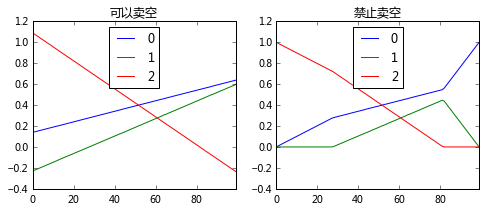

In [18]:
plt.figure(figsize=(8, 3))
ax1=plt.subplot(121)
pd.DataFrame(x['Weights']).plot(ax=ax1,title="可以卖空")
ax2=plt.subplot(122)
pd.DataFrame(x1['Weights']).plot(ax=ax2,title="禁止卖空",ylim=(-0.4,1.2))

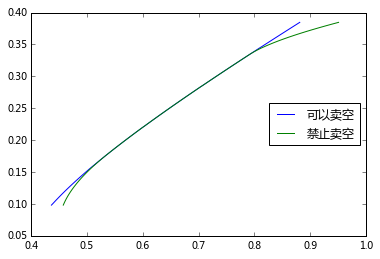

In [19]:
plt.figure()
plt.plot(x["Stds"],x["Means"],label="可以卖空")
plt.plot(x1["Stds"],x1["Means"],label="禁止卖空")
plt.legend(loc="center right")

In [20]:
start="2012-1-1"
end="2015-1-1"
freq="W-FRI"
close12_15=closes[start:end]
returnsw=calc_returns(close12_15,freq).dropna(how="any")
xw=calc_efficient_frontier(returnsw)
xw1=calc_efficient_frontier(returnsw,sellshort=False)

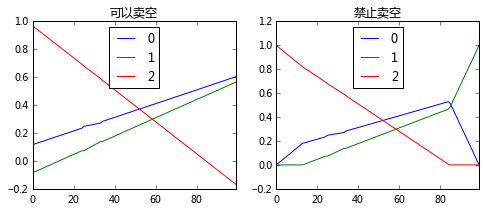

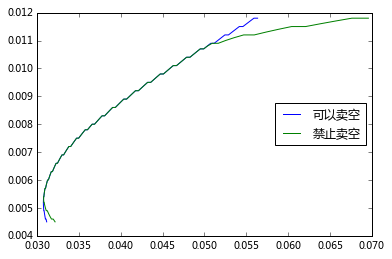

In [21]:
plt.figure(figsize=(8, 3))
ax1=plt.subplot(121)
pd.DataFrame(xw['Weights']).plot(ax=ax1,title="可以卖空")
ax2=plt.subplot(122)
pd.DataFrame(xw1['Weights']).plot(ax=ax2,title="禁止卖空",ylim=(-0.2,1.2))
plt.figure()
plt.plot(xw["Stds"],xw["Means"],label="可以卖空")
plt.plot(xw1["Stds"],xw1["Means"],label="禁止卖空")
plt.legend(loc="center right")

+ 切线组合计算
+ 优化sharpe ratio

In [25]:
def negative_sharpe_ratio( weights,means,sig,risk_free_rate = 0.015):
    # get the portfolio variance
    std = calc_portfolio_std(sigma=sig, weights=weights)  
    # and return the sharpe ratio
    return -((means.dot(weights) - risk_free_rate)/(std))
     

In [23]:
def optimize_portfolio(returns, risk_free_rate,sellshort=True):
    """ 
    Performs the optimization
    """
    means=returns.mean()
    sig=returns.cov()
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(returns.columns.size)]
        
    weights = np.ones(returns.columns.size, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    
    
    constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
    results = scopt.minimize(negative_sharpe_ratio, weights, (means,sig, risk_free_rate), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
    if not results.success: # handle error
        raise Exception(results.message)
    mean_sharpe=results.x.dot(means)    
    std_sharpe=calc_portfolio_std(sigma=sig,weights=results.x)
    return {'Means': mean_sharpe, 
            'Stds': std_sharpe, 
            'Weights': results.x}

    

In [26]:
risk_free_rate=0.06
T=optimize_portfolio(returns,risk_free_rate ,sellshort=False)
T

{'Means': 0.35231927631152166,
 'Stds': 0.83320937482961921,
 'Weights': array([ 0.71239557,  0.28760443,  0.        ])}

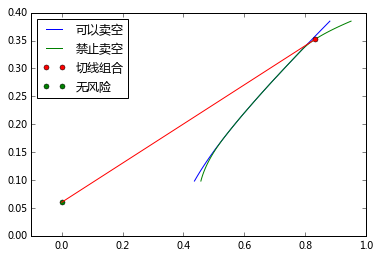

In [28]:
plt.figure()
plt.plot(x["Stds"],x["Means"],label="可以卖空")
plt.plot(x1["Stds"],x1["Means"],label="禁止卖空")
plt.plot(T["Stds"],T["Means"],"ro",markersize=5,label="切线组合")
plt.plot(0,risk_free_rate,"go",markersize=5,label="无风险")
plt.plot([0,T["Stds"]],[risk_free_rate,T["Means"]])
plt.xlim(-0.1,1)
plt.ylim(0,0.4)
plt.legend(loc="upper left")
